In [42]:
%load_ext autoreload
%autoreload 2

import numpy as np
from PIL import Image
import napari
import tifffile
from matplotlib import pyplot as plt
from skvideo import io as skvideo_io

from segbox import SegBox
from seghub.vgg16_utils import get_vgg16_feature_space
from seghub.dino_utils import get_dinov2_feature_space

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Create an instance of segbox called my_sb. Add a first feature extractor and print informations about my_sb.

In [43]:
my_sb = SegBox()
my_sb.add_extractor("VGG16-small", get_vgg16_feature_space, {"layer_list":[0], "scalings":[1,2], "rgb_if_possible":False})

In [44]:
print(my_sb)

Segmentation Box
OPTIONS:
  PCs as features: False
  IMG as feature:  False
  Smoothen preds:  False
RANDOM FOREST SETTINGS:
  Nr. estimators: 100
  Random state:   None
FEATURE EXTRACTORS:
VGG16-small:
  Function:    get_vgg16_feature_space
  Config:      {'layer_list': [0], 'scalings': [1, 2], 'rgb_if_possible': False}
  Num PCs:     False
  Smoothening: False



Remove the feature extractor and print my_sb again to verify.

In [45]:
my_sb.remove_extractor("VGG16-small")
print(my_sb)

Segmentation Box
OPTIONS:
  PCs as features: False
  IMG as feature:  False
  Smoothen preds:  False
RANDOM FOREST SETTINGS:
  Nr. estimators: 100
  Random state:   None
FEATURE EXTRACTORS:
  No extractors


Add a new feature extractor and print to verify. When adding another feature extractor with the same name, we get an error message.

In [46]:
my_sb.add_extractor("VGG16-large", get_vgg16_feature_space, {"layer_list":[0,2], "scalings":[1,2,4,8]})
print(my_sb)
my_sb.add_extractor("VGG16-large", get_vgg16_feature_space, {"layer_list":[0,2,5], "scalings":[1,2,4,8]})

Segmentation Box
OPTIONS:
  PCs as features: False
  IMG as feature:  False
  Smoothen preds:  False
RANDOM FOREST SETTINGS:
  Nr. estimators: 100
  Random state:   None
FEATURE EXTRACTORS:
VGG16-large:
  Function:    get_vgg16_feature_space
  Config:      {'layer_list': [0, 2], 'scalings': [1, 2, 4, 8]}
  Num PCs:     False
  Smoothening: False



ValueError: Extractor already exists. Use overwrite=True to overwrite it.

We can use `overwrite=True` to overwrite a feature extractor with the same name.

In [47]:
my_sb.add_extractor("VGG16-large", get_vgg16_feature_space, {"layer_list":[0,2,5], "scalings":[1,2,4,8]}, overwrite=True)
print(my_sb)

Segmentation Box
OPTIONS:
  PCs as features: False
  IMG as feature:  False
  Smoothen preds:  False
RANDOM FOREST SETTINGS:
  Nr. estimators: 100
  Random state:   None
FEATURE EXTRACTORS:
VGG16-large:
  Function:    get_vgg16_feature_space
  Config:      {'layer_list': [0, 2, 5], 'scalings': [1, 2, 4, 8]}
  Num PCs:     False
  Smoothening: False



Let's add a second feature extractor.

In [48]:
my_sb.add_extractor("DINOv2-s_r", get_dinov2_feature_space, {"dinov2_model":"s_r"})
print(my_sb)

Segmentation Box
OPTIONS:
  PCs as features: False
  IMG as feature:  False
  Smoothen preds:  False
RANDOM FOREST SETTINGS:
  Nr. estimators: 100
  Random state:   None
FEATURE EXTRACTORS:
VGG16-large:
  Function:    get_vgg16_feature_space
  Config:      {'layer_list': [0, 2, 5], 'scalings': [1, 2, 4, 8]}
  Num PCs:     False
  Smoothening: False
DINOv2-s_r:
  Function:    get_dinov2_feature_space
  Config:      {'dinov2_model': 's_r'}
  Num PCs:     False
  Smoothening: False



We can change the parameters for a feature extractor function by changing its config. Let's change the VGG16 layers back to [0, 2].

In [49]:
my_sb.set_extractor_cfg("VGG16-large", {"layer_list":[0,2], "scalings":[1,2,4,8]})

We can also change options such as principal components used or smoothening applied for each feature extractor individually.

In [50]:
my_sb.set_extractor_options("VGG16-large", num_pcs=3, smoothening=4)
print(my_sb)

Segmentation Box
OPTIONS:
  PCs as features: False
  IMG as feature:  False
  Smoothen preds:  False
RANDOM FOREST SETTINGS:
  Nr. estimators: 100
  Random state:   None
FEATURE EXTRACTORS:
VGG16-large:
  Function:    get_vgg16_feature_space
  Config:      {'layer_list': [0, 2], 'scalings': [1, 2, 4, 8]}
  Num PCs:     3
  Smoothening: 4
DINOv2-s_r:
  Function:    get_dinov2_feature_space
  Config:      {'dinov2_model': 's_r'}
  Num PCs:     False
  Smoothening: False



Let's load an image and according labels to test feature extraction and segmentation methods.

In [51]:
img = np.array(Image.open("../data/shark_test_vid_frame0.png")) / 255
labels = tifffile.imread("../data/shark_vid_labels_frame0.tif")

With the options chosen for a specific feature extractor, we can perform the feature extraction of that extractor alone.

In [52]:
features = my_sb.extract_features_single_extractor(img, "VGG16-large")
features.shape

(480, 640, 3)

Since we chose for the VGG16-large model to use 3 principal components only, we can display it as an RGB image.

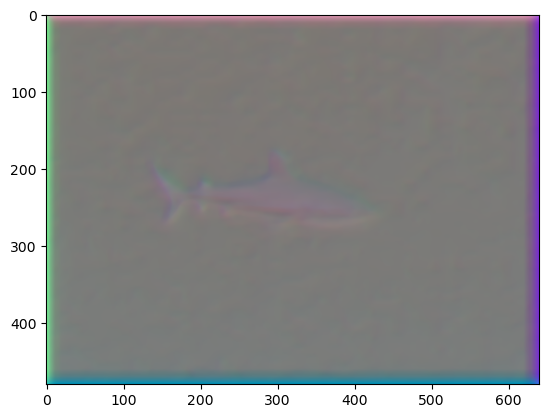

In [53]:
plt.imshow(features)
plt.show()

Most importantly, we can extract all combined features.

In [54]:
all_features = my_sb.extract_features(img)
all_features.shape

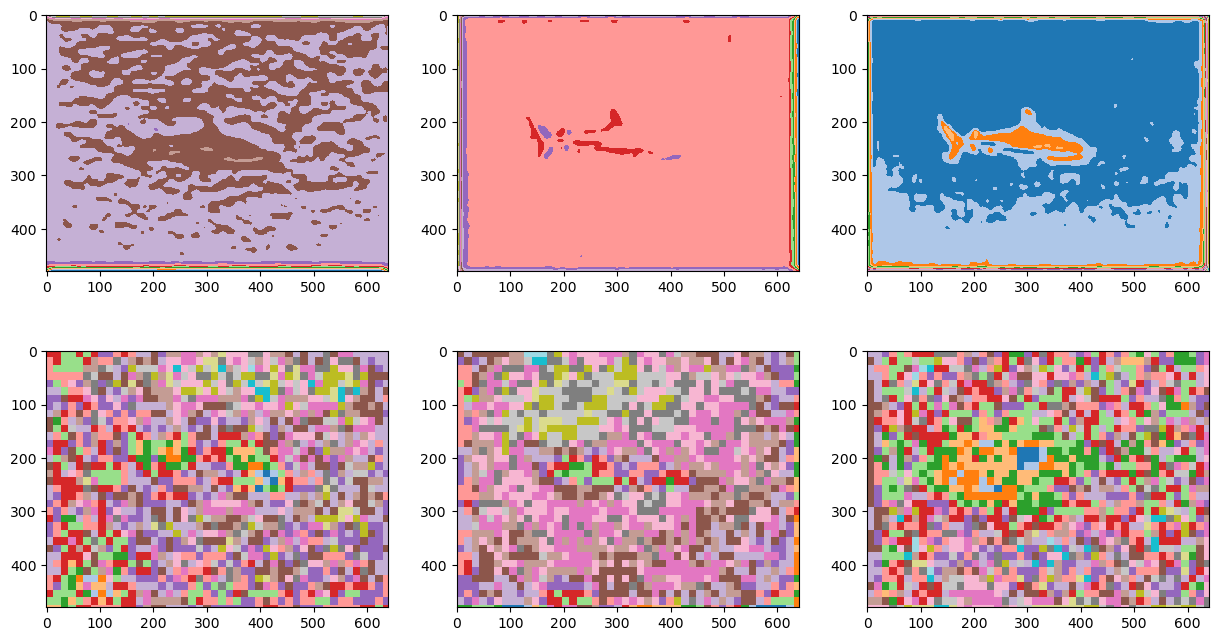

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

for i in range(6):
    ax.flatten()[i].imshow(all_features[:,:,i], cmap="tab20", interpolation="none")

Based on this feature extraction functionality, we can train a random forest classifier for an image and according annotations.

Let's first set the random state for the random forest for reproducibility, and then train the model.

In [ ]:
my_sb.set_rf_settings(n_estimators=100, random_state=0)
print(my_sb.get_rf_settings())
my_sb.rf_train(img, labels)

  Nr. estimators: 100
  Random state:   0



With the trained random forest inside my_sb, we can predict the segmentation of an image using the same feature extraction protocol.

In [ ]:
pred = my_sb.rf_predict(img)

There is also a method to perform training and prediction on the same image, extracting the features only once.

In [ ]:
selfpred = my_sb.rf_selfpredict(img, labels)

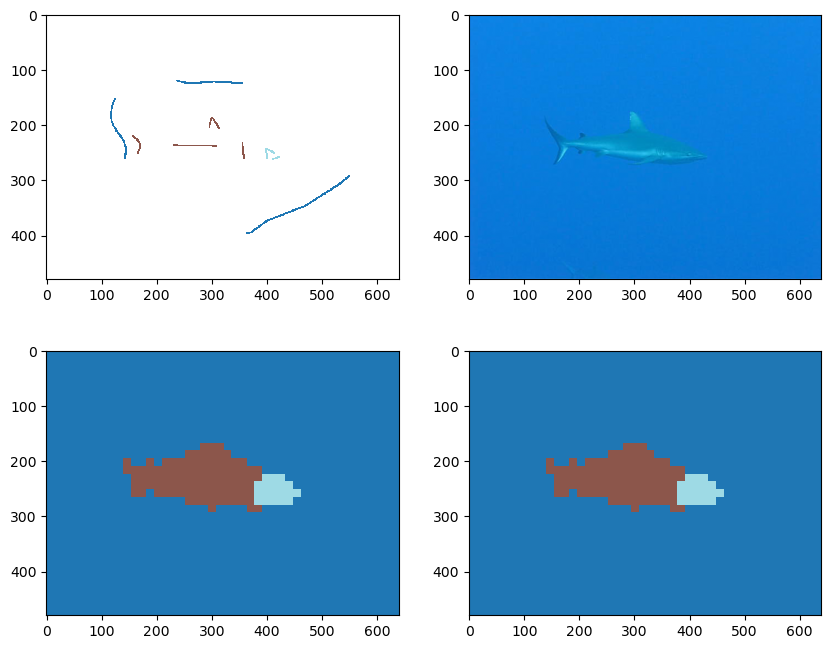

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,8))
labels_mask = labels>0
labels_masked = np.ma.masked_where(labels_mask==0, labels)
ax[0,0].imshow(labels_masked, cmap="tab20", interpolation="none")
ax[0,1].imshow(img)
ax[1,0].imshow(pred, cmap="tab20", interpolation="none")
ax[1,1].imshow(selfpred, cmap="tab20", interpolation="none")

Based on the combined features we can also perform an unsupervised clustering using the k-means algorithm.

In [ ]:
clusters = my_sb.get_kmeans(img, 3)

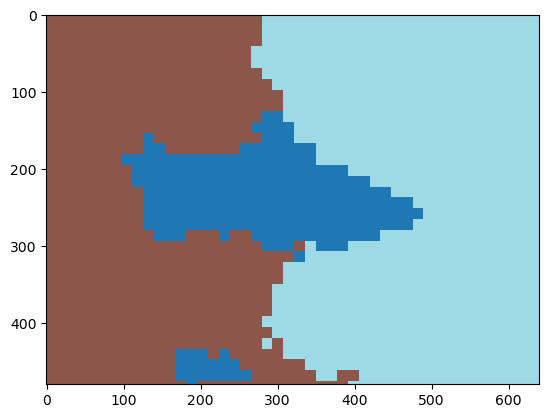

In [ ]:
plt.imshow(clusters, cmap="tab20", interpolation="none")

We can also add multiple feature extractors at once, which can speed up the generation of specific SegBox instances.

In [ ]:
new_sb = SegBox()
vgg16_l = {"func": get_vgg16_feature_space, "cfg": {"layer_list":[0,2], "scalings":[1,2,4,8]}}
vgg16_s = {"func": get_vgg16_feature_space, "cfg": {"layer_list":[0], "scalings":[1,2]}, "num_pcs": 3, "smoothening": 4}
dino_s_r = {"func": get_dinov2_feature_space, "cfg": {"dinov2_model":"s_r"}}
new_sb.add_extractors({"VGG16-large": vgg16_l, "VGG16-small": vgg16_s, "DINOv2-s_r": dino_s_r})
new_sb.set_rf_settings(n_estimators=100, random_state=0)
print(new_sb)

Segmentation Box
OPTIONS:
  PCs as features: False
  IMG as feature:  False
  Smoothen preds:  False
RANDOM FOREST SETTINGS:
  Nr. estimators: 100
  Random state:   0
FEATURE EXTRACTORS:
VGG16-large:
  Function:    get_vgg16_feature_space
  Config:      {'layer_list': [0, 2], 'scalings': [1, 2, 4, 8]}
  Num PCs:     False
  Smoothening: False
VGG16-small:
  Function:    get_vgg16_feature_space
  Config:      {'layer_list': [0], 'scalings': [1, 2]}
  Num PCs:     3
  Smoothening: 4
DINOv2-s_r:
  Function:    get_dinov2_feature_space
  Config:      {'dinov2_model': 's_r'}
  Num PCs:     False
  Smoothening: False



In [ ]:
print(new_sb.get_extractor_info("VGG16-large"))

VGG16-large:
  Function:    get_vgg16_feature_space
  Config:      {'layer_list': [0, 2], 'scalings': [1, 2, 4, 8]}
  Num PCs:     False
  Smoothening: False



Test the methods for batch handling.

In [ ]:
another_sb = SegBox()
another_sb.add_extractor("DINOv2_s-r", get_dinov2_feature_space, {"dinov2_model":"s_r"})

In [ ]:
img_batch = [img]*3
labels_batch = [np.zeros_like(labels)] + [labels] + [np.zeros_like(labels)]

Method to train on a batch of images and a batch of labels.

In [ ]:
another_sb.rf_train_batch(img_batch, labels_batch, print_progress=True)

Extracting features for labels 1/1 - estimated time left: NA


Predict on a batch of images. Also show that the history of predictions is being saved.

In [ ]:
another_sb.rf_predict_batch(img_batch, print_progress=True)
pred_batch = another_sb.prediction_history[-1]

Predicting image 1/3 - estimated time left: NA
Predicting image 2/3 - estimated time left: 11.7 seconds
Predicting image 3/3 - estimated time left: 5.5 seconds


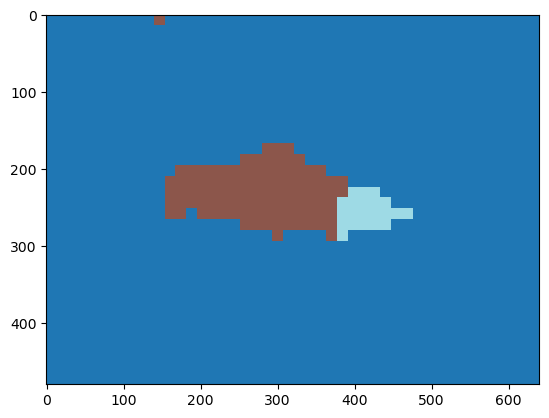

In [ ]:
plt.imshow(pred_batch[0], cmap="tab20", interpolation="none")

Method for direct training on one batch of images and labels and predicting on the same or another batch of images.

In [ ]:
another_sb.rf_segment([img]*3, [labels]+[np.zeros_like(labels)]*2, print_progress=True)
seg = another_sb.prediction_history[-1]

Extracting features for labels 1/1 - estimated time left: NA
Predicting image 1/3 - estimated time left: NA
Predicting image 2/3 - estimated time left: 10.0 seconds
Predicting image 3/3 - estimated time left: 5.0 seconds


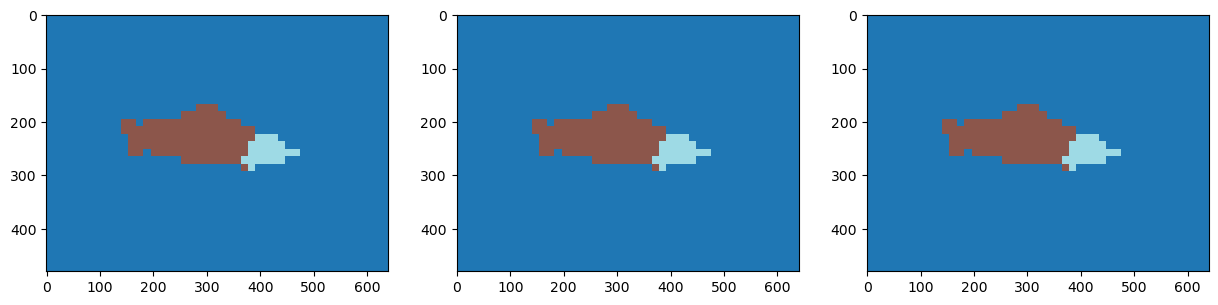

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    ax.flatten()[i].imshow(seg[i], cmap="tab20", interpolation="none")

Save a trained random forest model and information about feature extractors, options and random forest settings.

In [ ]:
my_sb = SegBox()
my_sb.add_extractor("VGG16-small", get_vgg16_feature_space, {"layer_list":[0], "scalings":[1,2], "rgb_if_possible":False})
print(my_sb)

Segmentation Box
OPTIONS:
  PCs as features: False
  IMG as feature:  False
  Smoothen preds:  False
RANDOM FOREST SETTINGS:
  Nr. estimators: 100
  Random state:   None
FEATURE EXTRACTORS:
VGG16-small:
  Function:    get_vgg16_feature_space
  Config:      {'layer_list': [0], 'scalings': [1, 2], 'rgb_if_possible': False}
  Num PCs:     False
  Smoothening: False



In [ ]:
my_sb.rf_train(img, labels)

In [ ]:
my_sb.rf_save("../data/vgg16-s-noRGB_rf")

Create a new SegBox object and load the saved random forest model into it (first assure they use the same options/settings).

In [ ]:
loaded_sb = SegBox()
loaded_sb.add_extractor("VGG16-small", get_vgg16_feature_space, {"layer_list":[0], "scalings":[1,2], "rgb_if_possible":False})
loaded_sb.rf_load("../data/vgg16-s-noRGB_rf")
print(loaded_sb)

IMPORTANT: The loaded file was saved with the following settings, please assure that the current settings are compatible:

Segmentation Box
OPTIONS:
  PCs as features: False
  IMG as feature:  False
  Smoothen preds:  False
RANDOM FOREST SETTINGS:
  Nr. estimators: 100
  Random state:   None
FEATURE EXTRACTORS:
VGG16-small:
  Function:    get_vgg16_feature_space
  Config:      {'layer_list': [0], 'scalings': [1, 2], 'rgb_if_possible': False}
  Num PCs:     False
  Smoothening: False

Segmentation Box
OPTIONS:
  PCs as features: False
  IMG as feature:  False
  Smoothen preds:  False
RANDOM FOREST SETTINGS:
  Nr. estimators: 100
  Random state:   None
FEATURE EXTRACTORS:
VGG16-small:
  Function:    get_vgg16_feature_space
  Config:      {'layer_list': [0], 'scalings': [1, 2], 'rgb_if_possible': False}
  Num PCs:     False
  Smoothening: False



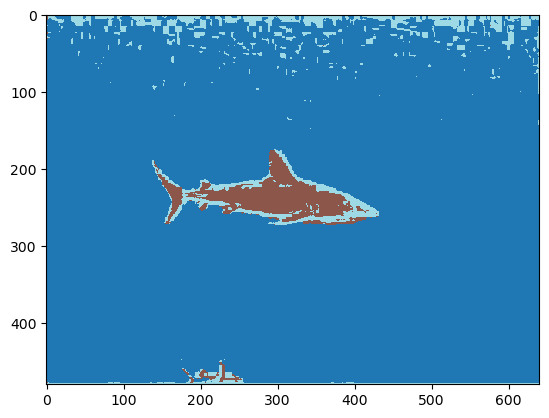

In [ ]:
pred_loaded = loaded_sb.rf_predict(img)
plt.imshow(pred_loaded, cmap="tab20", interpolation="none")